The goal of this notebook is to test the GP with the Gaussian conditional likelihood assumption.

In [1]:
import importlib
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

torch.manual_seed(33333)
%matplotlib inline

In [2]:
import razor_data
import plotting
import gp
importlib.reload(razor_data);
importlib.reload(plotting);

### Squared exponential kernel

In [3]:
debug = False

# data
num_mr_bins = 50
mr_max = 1200
binned_data = razor_data.get_binned_data_1d(
    num_mr_bins=num_mr_bins, mr_max=mr_max)
test_data = binned_data['MultiJet'][1]
U = test_data['u']
Y = test_data['y']

# model
test_ell = 40
test_alpha = 1000
test_kernel = gp.SquaredExponentialKernel(test_ell, test_alpha)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y)

# gradient ascent
sgd = torch.optim.SGD([
        {'params': G.kernel.ell, 'lr':1.0},
        {'params': G.kernel.alpha, 'lr':10.0},
        ])
for i in range(3000):
    sgd.zero_grad()
    G.clear()
    nlogp = G.neg_log_p()
    nlogp.backward()
    sgd.step()
    if debug:
        print("{}: {:.2f} {:.2f}".format(i, 
            test_kernel.ell.data.numpy()[0], 
            test_kernel.alpha.data.numpy()[0],
                                        ))

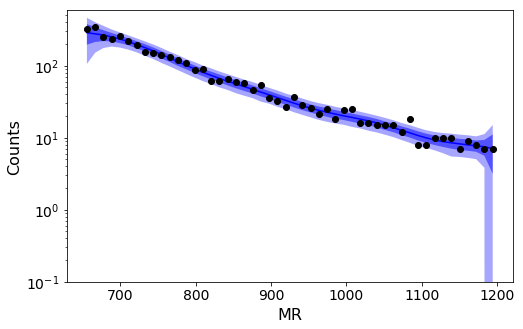

In [4]:
plotting.plot_hist_1d(test_data, G=G)

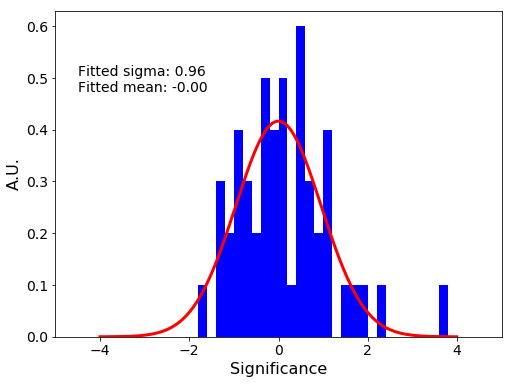

In [5]:
plotting.plot_nsigma_1d(test_data, G)

In [6]:
for p in G.parameters():
    print(p.data.numpy()[0])

98.4516
1624.06


It works for this case (for some hyperparameter choices).  But the SGD for the kernel hyperparameters never seems to converge.  The covariance strength gets larger and larger without bound.  Guesses:

1) maybe the gradient calculation is numerically unstable; we are doing backprop through a Cholesky decomposition and a matrix inverse.

2) maybe the kernel is not appropriate for this case -- it assumes a constant covariance strength, but our function ranges over many orders of magnitude so it would be better if the typical fluctuation size changed with MR.

First I will test (1) by comparing the log likelihood values and their gradients with other GP implementations.

Second I will test (2) by fitting the log of the number of counts, which will not require the posterior function to range over many orders of magnitude.  I will also implement the 'physics-aware' kernel in the Frate et al. paper, which has a covariance strength that is exponentially decreasing.

### Sanity check with scikit-learn

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [8]:
# data
num_mr_bins = 50
mr_max = 1200
binned_data = razor_data.get_binned_data_1d(
    num_mr_bins=num_mr_bins, mr_max=mr_max)
test_data = binned_data['MultiJet'][1]
U = test_data['u']
Y = test_data['y']

U_sk = U.unsqueeze(1).numpy()
ell = 40.
alpha = 300.
noise = 10
sk_kernel = RBF(length_scale=ell) * C(constant_value=alpha)
sk_gp = GaussianProcessRegressor(kernel=sk_kernel, alpha=noise)
sk_gp.fit(U_sk, Y.numpy())
print("sk_gp:", sk_gp.log_marginal_likelihood(
    theta=[np.log(ell), np.log(alpha)])) #sk stores these in log form

test_kernel = gp.SquaredExponentialKernel(ell, alpha)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y, sigma2=noise)
print("my_gp:", -G.neg_log_p().data.numpy()[0])

sk_gp: -594.560867767
my_gp: -594.561


It matches.  

In [9]:
np.exp(sk_gp.kernel_.theta)

array([    232.56709525,  100000.        ])

The scikit-learn fit routine (which uses a different optimizer) actually did a very similar thing to mine -- drove the covariance scale up as high as possible while having a length scale O(100).  That supports the conclusion that this is not a good kernel for the problem.

In [10]:
sk_grad = sk_gp.log_marginal_likelihood(
    theta=[np.log(ell), np.log(alpha)], eval_gradient=True)[1]
print("SK grad with resp to each parameter: {:.3f} {:.3f}".format(
    sk_grad[0]/ell, sk_grad[1]/alpha))

sgd = torch.optim.SGD(G.parameters(), lr=0.1)
sgd.zero_grad()
G.clear()
nlogp = G.neg_log_p()
nlogp.backward()
print("My grad with resp to each parameter: {:.3f} {:.3f}".format(
    G.kernel.ell.grad.data.numpy()[0],
    G.kernel.alpha.grad.data.numpy()[0]
))

SK grad with resp to each parameter: 0.248 0.706
My grad with resp to each parameter: -0.248 -0.706


The sign difference is because I am computing negative log marginal likelihood.  To get a match I had to divide the scikit gradient by the parameter values, because scikit optimizes the exponentials of the kernel parameters.

Everything seems to check out.